(ch:probability-discrete)=
# 이산확률분포

**기본 설정**

`numpy`와 `pandas` 라이브러리를 각각 `np`와 `pd`로 불러온다.

In [1]:
import numpy as np
import pandas as pd

데이터프레임의 [chained indexing을 금지시키기 위한 설정](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy)을 지정한다.
Pandas 3.0 버전부터는 기본 옵션으로 지정된다.

In [2]:
pd.options.mode.copy_on_write = True

주피터 노트북에서 부동소수점의 출력을 소수점 이하 6자리로 제한한다.
아래 코드는 주피터 노트북에서만 사용하며 일반적인 파이썬 코드가 아니다.

In [3]:
%precision 6

'%.6f'

아래 코드는 데이터프레임 내에서 부동소수점의 출력을 소수점 이하 6자리로 제한한다.

In [4]:
pd.set_option('display.precision', 6)

코드에 사용되는 [데이터 저장소의 기본 디렉토리](https://github.com/codingalzi/DataSci/tree/master/data)를 지정한다.

In [5]:
data_url = 'https://raw.githubusercontent.com/codingalzi/DataSci/refs/heads/master/data/'

데이터 시각화를 위해 `matplotlib.pyplot`를 `plt`라는 별칭으로 불러온다.

In [6]:
import matplotlib.pyplot as plt

**주요 내용**

이 장에서는 이산확률분포와 다변량 분포의 주요 개념들을 소개한다. 구체적으로, 이산확률변수를 이용한 확률질량함수, 누적분포함수, 결합확률분포, 조건부확률, 주변확률분포 등의 개념을 다룬다.

## 이산확률변수

{numref}`%s장 <ch:probability>`에서 살펴본 확률변수는 주사위를 던져 나오는 값이나 가구소득 범주를 나타내는 1부터 5까지의 정수 레이블처럼, 확률변수가 취할 수 있는 값이 $x_1$, $x_2$, $x_3$ ... 식으로 셀 수 있다. 이러한 확률변수를 **이산확률변수 <font size='2'>discrete random variable</font>**라 하고, 이산확률변수가 따르는 확률분포를 **이산확률분포 <font size='2'>discrete probability distribution</font>**라 한다.

**예제: 가구소득 범주의 이산확률분포**

캘리포니아 주택가격 데이터셋에서 가구소득 범주의 이산확률분포를 나타내는 데이터프레임을 이미 생성한 바 있다. 하지만 이 장의 뒷부분에서 다변량 분포를 다루기 위해 주택가격 범주의 이산확률분포를 구해야 하므로, 앞 장의 내용을 압축적으로 요약하며 동일 데이터프레임 생성과정을 다시한번 반복한다. 각 과정의 의미는 모두 주석으로 대체한다.

In [7]:
# 데이터셋을 불러온 후, 가구소득과 주택가격만 활용
housing = pd.read_csv(data_url+"california_housing.csv")
housing = housing.loc[:, ['median_income', 'median_house_value']]

# 데이터 이상치(주택가격 50만 초과)를 삭제하고 인덱스 초기화
house_value_max = housing['median_house_value'].max() # 500,001
mask = housing['median_house_value'] >= house_value_max
housing = housing[~mask]
housing = housing.reset_index(drop=True)
housing.index.name = 'district'

# 가구소득 범주 특성 추가
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# 가구소득 범주별로 그룹화하고 구간별 도수 및 상대도수 계산
x_stratification = housing.iloc[:, [0, 2]].groupby('income_cat', observed=True, group_keys=True)
x_stratified_count = x_stratification.count()
x_stratified_ratio = x_stratified_count/(housing.shape)[0]

x_stratified_ratio

,median_income
income_cat,
1,0.041372
2,0.333011
3,0.361017
4,0.177992
5,0.086607


마지막으로, 위 데이터프레임의 상대도수를 가구소득 범주로 정의된 확률변수 $X$에 대한 확률분포표 형태로 변환한다.

In [8]:
# 데이터프레임으로 변환
prob_income = x_stratified_ratio.iloc[:, 0:1]
# 컬럼과 인덱스 이름 지정
prob_income.columns = ['확률']
prob_income.index.name = 'X'

# 가로형의 데이터프레임으로 변환
prob_income = prob_income.T
prob_income

X,1,2,3,4,5
확률,0.041372,0.333011,0.361017,0.177992,0.086607


### 확률질량함수(PMF)

이산확률변수  $X$가 취할 수 있는 각 값 $x$에 대해
그 값이 나타날 확률 $P(X = x)$를 대응시키는 함수 $f$ 를
**확률질량함수 <font size='2'>probability mass function(PMF)</font>**라고 하며, 다음과 같이 표기한다.

$$
f(x) = P(X = x)
$$

**확률의 성질**

이산확률분포가 주어졌을 때 모든 경우에 대한 확률은 0과 1사이의 값이고, 모든 확률의 합은 1이다.
즉 다음이 성립해야 한다.


- 첫째, 확률변수가 취할 수 있는 임의의 값 $x_k$에 대한 확률은 0과 1 사이의 값이다.

    $$0 \le f(x_k) \le 1$$

- 둘째, 확률변수가 취할 수 있는 모든 값에 대한 확률의 합은 1이다.
    $$\sum_k f(x_k) = 1$$


가구소득 범주로 정의된 확률변수 $X$ 또한 위 성질을 모두 만족한다.

- 모든 확률은 0과 1사이의 값

In [9]:
(0 <= prob_income) & (prob_income <= 1) # 판다스의 요소별 논리 연산 "AND"

X,1,2,3,4,5
확률,True,True,True,True,True


다음 방식으로 확인해도 되는데,
`all()` 함수에 `axis=1`을 사용해서
모든 열에 대해 참인 경우에만 `True`를 출력하도록 한다.

In [10]:
((0 <= prob_income) & (prob_income <= 1)).all(axis=1)

확률    True
dtype: bool

- 모든 확률의 합은 1

In [11]:
prob_income.sum(axis=1)

확률    1.0
dtype: float64

### 누적분포함수(CDF)

이산확률변수 $X$가 $x$보다 같거나 작은 값을 가질 확률 $P(X \leq x)$을
**누적분포함수<font size='2'>cumulative distribution function</font>(CDF)**라고 부르며
아래처럼 정의한다.

$$
F(x) = P(X \le x) = \sum_{x_k \le x} f(x_k)
$$

따라서 가구소득 범주로 정의된 이산확률변수 $X$의 누적분포함수 CDF는 확률분포 `prob_income`에 리스트 컴프리헨션 <font size='2'>list comprehension</font> 기법을 적용해 다음과 같이 정의할 수 있다.
 `prob_income.columns` (가구소득 범주의 레이블들)에 포함된 각각의 $x_k$에 대해서 $x_k \leq x$인 경우의 `prob_income[x_k]`들만 모아서 리스트를 생성하고, 그 원소들을 더한다.

In [12]:
def income_cdf(x):
    return np.sum([prob_income[x_k] for x_k in prob_income.columns if x_k <= x])

:::{admonition} 리스트 컴프리헨션(list comprehension) :class: note

리스트 컴프리헨션은 파이썬에서 반복문이나 조건문을 사용하여 기존 리스트나 다른 이터러블(순회 가능한 객체)로부터 새로운 리스트를 만들 때 매우 유용하다.
기본 문법은 `[표현식 for 항목 in 이터러블 if 조건]`이다.
- 표현식: 리스트에 추가될 값을 정의. 뒤의 for문에서 얻은 항목을 그대로 사용하거나 연산을 수행하는 표현.
- `for` 항목 `in` 이터러블: 순회 가능한 객체 (예: 리스트, 튜플, 문자열, 레인지, 데이터프레임의 컬럼 등)의 각 항목을 차례로 순회.
if 조건(선택사항): 이터러블의 항목 중에서 이 조건을 만족하는 항목들만 표현식을 거쳐 리스트에 포함됨.

:::

:::{admonition} 파이썬에서의 함수 정의 :class: note

파이썬에서는 `def` 키워드를 사용하여 함수를 정의하며, 기본 문법은 다음과 같다.

`def` 함수_이름(매개변수1, 매개변수2, ...):
     #함수 본문: 함수가 호출될 때 실행되는 코드
  `return` 결과 (선택 사항)

:::

위에서 정의한 확률변수 $X$의 CDF를 사용해 가구소득 범주가 3 이하일 확률을 확인할 수 있다.

In [13]:
income_cdf(3)

0.735400

## 다변량 분포

**다변량 분포**<font size='2'>multivariate distribution</font>는
여러 개의 확률변수들이 결합된 확률분포를 말한다. 여기서는 두 개의 이산확률변수가 결합된 다변량 분포를 소개한다.

### 이산결합확률분포

두 이산확률변수 $X$와 $Y$에 대해,
결합확률변수 $(X, Y)$는 $X$가 취할 수 있는 값과
$Y$가 취할 수 있는 값의 모든 가능한 순서쌍 $(x, y)$을 나타낸다. 이러한 순서쌍 $(x, y)$ 각각이 발생할 확률들의 분포를 **이산결합확률분포 <font size='2'>discrete joint probability distribution</font>**라고 한다.

이산결합확률분포의 확률질량함수는 **결합확률질량함수 <font size='2'>joint probability mass function</font>**라 부르며, 확률변수 $X$는 $x$를 취하고 동시에 확률변수 $Y$는 $y$를 취할 확률로서 다음과 같이 정의한다.

$$
f_{XY}(x, y) = P(X=x, Y=y)
$$

여기서 $P(X=x, Y=y)$는
$P(X=x \;\cap\; Y=y)$ 또는
$P(X=x \;\;\text{and}\;\; Y=y)$와 정확히 같은 의미로 쓰인다.

**예제: 가구소득 범주와 주택가격 범주**

이제 캘리포니아 주택가격 데이터셋의 주택가격을 6개의 구간으로 나눠 주택가격 범주를 가르키는 새로운 이산확률변수 $Y$를 정의해보자. 가구소득 범주의 경우와 유사한 방식으로 작업을 진행하면 된다.

주택가격의 범위는 14,999부터 500,000까지다.

In [14]:
housing.median_house_value.describe()

count     19675.000000
mean     192477.921017
std       97711.509613
min       14999.000000
25%      116600.000000
50%      173800.000000
75%      248200.000000
max      500000.000000
Name: median_house_value, dtype: float64

주택가격의 사분위수 정보를 이용하여 주택가격을 6개 범주로 나눈다.

In [15]:
housing["value_cat"] = pd.cut(housing["median_house_value"],
                              bins=[0, 50_000, 100_000, 150_000, 250_000, 400_000, np.inf],
                              labels=range(1, 7))

housing

,median_income,median_house_value,income_cat,value_cat
district,,,,
0,8.3252,452600.0,5,6
1,8.3014,358500.0,5,5
2,7.2574,352100.0,5,5
3,5.6431,341300.0,4,5
4,3.8462,342200.0,3,5
...,...,...,...,...
19670,1.5603,78100.0,2,2
19671,2.5568,77100.0,2,2
19672,1.7000,92300.0,2,2


주택가격 범주별로 그룹화하고 그룹별 도수와 상대도수를 확인한다.

In [16]:
y_stratification = housing.iloc[:, [1, 3]].groupby('value_cat', observed=True, group_keys=True)
y_stratified_count = y_stratification.count()
y_stratified_ratio = y_stratified_count/(housing.shape)[0]
y_stratified_ratio

,median_house_value
value_cat,
1,0.010673
2,0.175248
3,0.201372
4,0.367878
5,0.205235
6,0.039593


주택가격 범주로 정의된 확률변수 $Y$의 확률분포는 다음과 같다.

In [17]:
prob_value = y_stratified_ratio.iloc[:, 0:1]
prob_value.columns = ['확률']
prob_value.index.name = 'Y'

prob_value = prob_value.T
prob_value

Y,1,2,3,4,5,6
확률,0.010673,0.175248,0.201372,0.367878,0.205235,0.039593


참고로 가구소득 범주로 정의된 확률변수 $X$의 확률분포는 다음과 같다.

In [18]:
prob_income

X,1,2,3,4,5
확률,0.041372,0.333011,0.361017,0.177992,0.086607


두 확률변수의 확률분포를 그래프로 그리면 다음과 같다.

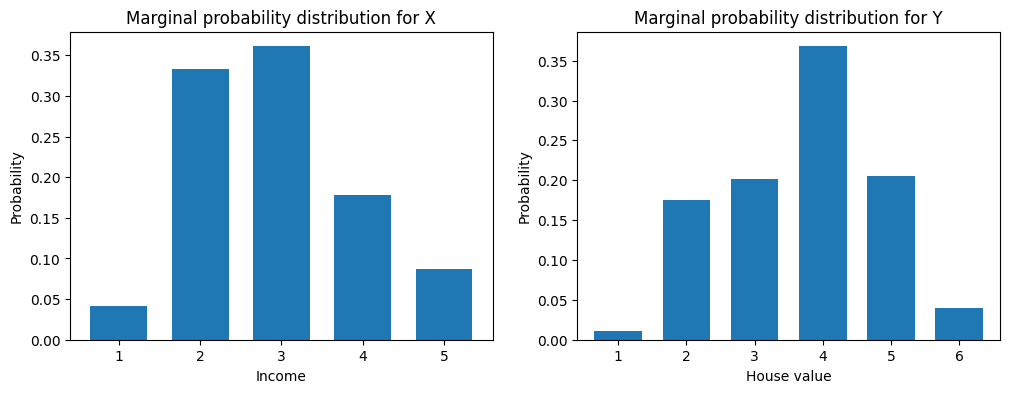

In [19]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

prob_income.T.plot(ax=ax1, kind='bar', rot=0, legend=False, width=.7)
ax1.set_title('Marginal probability distribution for X')
ax1.set_xlabel('Income')
ax1.set_ylabel('Probability')

prob_value.T.plot(ax=ax2, kind='bar', rot=0, legend=False, width=.7)
ax2.set_title('Marginal probability distribution for Y')
ax2.set_xlabel('House value')
ax2.set_ylabel('Probability')

plt.show()

**확률변수 $X$, $Y$의 확률질량함수**

먼저 확률변수 $X$와 확률변수 $Y$의 확률질량함수를 각각 정의하자.

In [20]:
def p_X(x):
    return prob_income[x].iloc[0]
def p_Y(y):
    return prob_value[y].iloc[0]

**결합확률질량함수(Joint PMF)**

캘리포니아 주택가격 데이터셋에 포함된 총 19,675개의 구역에서 한 구역을 임의로 선택했을 때,
해당 구역의 가구소득 범주는4, 주택가격 범주는 3일 확률 $P(X=4, Y=3)$을 계산해보자.

먼저 두 확률변수 $X$와 $Y$는 상호 독립적인 관계가 아닐 가능성이 높음에 주목하자. 이유는 일반적으로 가구소득이 높은 지역일수록 주택가격도 높은 편이기 때문이다.
실제로 두 특성 사이의 상관계수가 0.64 정도로 높은 편이며,
이는 $P(X=4, Y=3)$와 $P(X=4)\cdot P(Y=3)$가 다를 가능성이 높음을 의미한다.

In [21]:
housing.iloc[:, :2].corr()

,median_income,median_house_value
median_income,1.000000,0.642611
median_house_value,0.642611,1.000000


결합확률질량함수 $P(X=x, Y=y)$는 확률변수 $X$가 값 $x$를 갖고 동시에 확률변수 $Y$가 값 $y$를 가질 확률이므로, 두 변수의 특정 조합 $(x, y)$이 전체 데이터에서 얼마나 자주 발생하는지를 통해 계산할 수 있다. 판다스의 `crosstab()` 함수를 사용하면 각 조합의 발생 빈도를 쉽게 집계할 수 있다.

먼저 가구소득 범주와 주택가격 범주만 별도의 데이터프레임으로 만든다.

In [22]:
two_cats = housing.iloc[:, -2:]
two_cats

,income_cat,value_cat
district,,
0,5,6
1,5,5
2,5,5
3,4,5
4,3,5
...,...,...
19670,2,2
19671,2,2
19672,2,2


`pd.crosstab()` 함수는 두 범주 특성에 대한 **교차표**<font size='2'>cross table</font>, 즉 두 범주 특성의 가능한 모든 조합에 대한 도수가 계산된다. `margins=True` 인자는 행별, 열별 도수의 합을 집계한 행과 열도 추가시킨다.

In [23]:
cats_crossed = pd.crosstab(two_cats.iloc[:, 0], two_cats.iloc[:, 1], margins=True)
cats_crossed

value_cat,1,2,3,4,5,6,All
income_cat,,,,,,,
1,72,436,159,108,33,6,814
2,131,2335,1880,1799,358,49,6552
3,6,650,1652,3343,1273,179,7103
4,1,24,251,1753,1289,184,3502
5,0,3,20,235,1085,361,1704
All,210,3448,3962,7238,4038,779,19675


교차표에 인덱싱을 적용하면 임의의 $x$와 $y$에 대해 $P(X=x, Y=y)$를 계산할 수 있다. $P(X=4, Y=3)$는 아래 두 항목의 비율이므로
- `cats_crossed.loc[4, 3]`: 가구소득 범주 4, 주택가격 범주  3인 경우의 도수
- `cats_crossed.loc['All', 'All']`: 모집단 크기

$P(X=4, Y=3)$는 다음과 같이 계산된다.

In [24]:
cats_crossed.loc[4, 3] / cats_crossed.loc['All', 'All']

0.012757

따라서 가구소득 범주와 주택가격 범주의 결합확률분포를 따르는 결합확률질량함수는 다음과 같이 정의된다.

In [25]:
def p_XY(x, y):
    return  cats_crossed.loc[x, y] / cats_crossed.loc['All', 'All']

캘리포니아 주택가격 데이터셋에서 임의의 구역을 선택했을 때 가구소득 범주는 4, 주택가격 범주는 3인 경우의 확률은 다음과 같고

In [26]:
p_XY(4, 3)

0.012757

캘리포니아 주택가격 데이터셋에서 임의의 구역을 선택했을 때 가구소득 범주는 5, 주택가격 범주는 6인 경우의 확률은 다음과 같다.

In [27]:
p_XY(5, 6)

0.018348

참고로 두 확률변수가 서로 영향을 주지 않는다면, 위 결과가 $P(X=5)\cdot P(Y=6)$과 같아야 하는데, 그렇지 않다. 따라서 두 확률변수 $X$와 $Y$는 독립이 아니다.

In [28]:
p_X(5) * p_Y(6)

0.003429

**확률의 성질**

이산결합확률분포에 대해서도 확률의 두 가지 성질을 확인해보자.

첫째, 두 확률변수 $X$, $Y$가 취할 수 있는 임의의 값 $x$와 $y$에 대한 확률은 0과 1 사이의 값이다.

브로드캐스팅 기능을 통해 모든  $x$와 $y$의 조합에 대해 $P(X=x, Y=y)$를 쉽게 구할 수 있다. 아래 데이터프레임의 각 항목이 0과 1사이의 값인지를 확인하면 된다.

In [29]:
p_XY_df = cats_crossed / cats_crossed.loc['All', 'All']
p_XY_df

value_cat,1,2,3,4,5,6,All
income_cat,,,,,,,
1,0.003659,0.022160,0.008081,0.005489,0.001677,0.000305,0.041372
2,0.006658,0.118679,0.095553,0.091436,0.018196,0.002490,0.333011
3,0.000305,0.033037,0.083964,0.169911,0.064701,0.009098,0.361017
4,0.000051,0.001220,0.012757,0.089098,0.065515,0.009352,0.177992
5,0.000000,0.000152,0.001017,0.011944,0.055146,0.018348,0.086607
All,0.010673,0.175248,0.201372,0.367878,0.205235,0.039593,1.000000


In [30]:
(0 <= p_XY_df).all().all()

True

In [31]:
(1 >= p_XY_df).all().all()

True

둘째, 두 확률변수가 취할 수 있는 모든 조합에 대한 확률의 합은 1이다.

`p_XY_df.loc['All', 'All']` 또는 다음의 값이 1임을 확인하면 된다.

In [32]:
p_XY_df.iloc[-1, -1]

1.000000

**이산결합확률분포의 히트맵**

영역별 값의 크기를 색과 농도로 구분하는 히트맵을 이용하면
가구소득 범주와 주택가격 범주 사이의 연관성을 한 눈에 알아볼 수 있다.

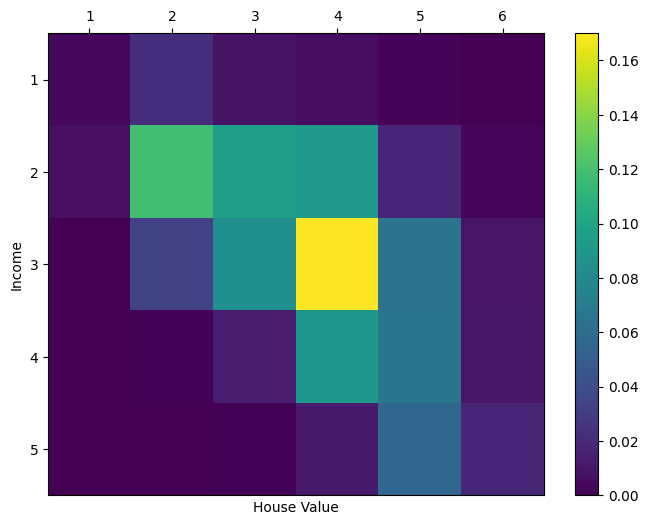

In [33]:
fig = plt.figure(figsize=(8,6))
hx = fig.add_subplot(1, 1, 1)

row, col = p_XY_df.shape

# 마지막 행과 열 제외
row -= 1
col -= 1

# 히트맵
c = hx.pcolor(p_XY_df.iloc[:row, :col])

# 축 눈금 지정
hx.set_xticks(np.arange(col) + 0.5, minor=False)
hx.set_yticks(np.arange(row) + 0.5, minor=False)

hx.set_xticklabels(range(1, col+1))
hx.set_yticklabels(range(1, row+1))

hx.invert_yaxis() # 가구소득 범주 위에서부터
hx.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False) # x축 눈금은 위쪽
                                                                         # y축 눈금은 기본값인 왼쪽

hx.set_xlabel('House Value')
hx.set_ylabel('Income')

fig.colorbar(c, ax=hx) # 색 기둥

plt.show()

대각선에 위치한 영역의 일반적으로 밝다.
특히 가구소득의 범주가 3, 주택가격의 범주가 4인 영역의 확률이 가장 높다.
일반적으로 가구소득 수준과 주택가격의 수준이 비례한다는 점과
중산층이 적정한 가격의 주택에 산다는 상식에 부합하는 결과인 셈이다.

### 조건부확률

**조건부확률**<font size='2'>conditional probability</font> $P(A\mid B)$는 사건 $B$가 일어났다는 전제 하에 사건 $A$가 발생할 확률을 나타내며,
아래 그림에서 파랑색 영역 $B$에서 보라색 영역이 차지하는 비율을 가리킨다.
반면에 $P(A)$, $P(B)$, $P(A, B)$는 전체 검정색 영역 $U$에서
각각의 영역이 차지하는 비율을 가리킨다.

<p><div align="center"><img src="https://github.com/codingalzi/DataSci/blob/master/jupyter-book/images/conditional02.png?raw=true" style="width:300px"></div></p>

따라서 조건부확률 $P(A \mid B)$는 전체 영역 $U$에서 보라색 영역이 차지하는 비율인 $P(A, B)=P(A \;\cap\; B)$과 다르지만, 다음의 관계식을 만족한다.
$$
P(A\mid B) = \frac{P(A, B)}{P(B)}\qquad (\ast)
$$

위 그림의 영역들의 면적을 이용해 이를 쉽게 보일 수 있다.

$$
P(A\mid B) = \frac{area(A \;\cap\; B)}{area(B)}
= \frac{\frac{area(A \;\cap\; B)}{area(U)}}{\frac{area(B)}{area(U)}}
= \frac{P(A \;\cap\; B)}{P(B)}
$$

:::{admonition} 예제
:class: example

15명으로 구성된 동아리가 진행하는 행사에 참여하는 회원의 정보가 다음과 같다.

|  | 여성(0) | 남성(1) | 합계 |
| :---: | :---: | :---:| :---: |
| 불참(0) | 2 | 2 | 4 |
| 참여(1) | 6 | 5 | 11 |
| 합계 | 8 | 7 | 15 |

15명 중에 한 명을 임의로 선택할 때
확률변수 $X$는 불참이면 0, 참여하면 1이라는 값을,
확률변수 $Y$는 여성이면 0, 남성이면 1이라는 값을 갖는다고 하자.

그러면 임의로 선택된 사람이 여성일 때 그 여성이 행사에 참여할 확률
$P(X=1 \mid Y=0)$은 총 8명의 여성회원 중에서 행사에 참여하는
6명의 비율인 3/4이다.
반면에, 임의로 선택된 사람이 행사에 참여하는 여성일 확률 $P(X=1, Y=0)$은
총 15명 중에 6명의 비율인 6/15이다.
$P(Y=0)=8/15$이므로, 식 $(*)$을 이용해도 동일한 조건부확률 3/4을 얻는다.

$$
P(X=1 \mid Y=0) = \frac{P(X=1, Y=0)}{P(Y=0)} = \frac{\frac{6}{15}}{\frac{8}{15}} = \frac 6 8 = \frac 3 4
$$
:::

조건부확률 $P(X=x\mid Y=y)$를 계산하기 위해 $(*)$를 이용한다.

$$
P(X=x\mid Y=y) = \frac{P(X=x, Y=y)}{P(Y=y)}
$$

`X`와 `Y`의 역할을 바꾸면 다음도 성립한다.

$$
P(Y=y\mid X=x) = \frac{P(Y=y, X=x)}{P(X=x)} = \frac{P(X=x, Y=y)}{P(X=x)}
$$

**조건부확률의  확률질량함수**

조건부확률의 확률질량함수를 앞서 정의한 확률질량함수들과 위 계산식을 이용해
간단하게 정의할 수 있다.

- $P(X=x \mid Y=y)$ 계산 함수

In [34]:
def p_XconY(x, y):
    return p_XY(x, y) / p_Y(y)

- $P(Y=y \mid X=x)$ 계산 함수

In [35]:
def p_YconX(y, x):
    return p_XY(x, y) / p_X(x)

예를 들어, 캘리포니아 주택가격 데이터셋에서 주택가격의 범주가 3인 구역을 임의로 하나 선택했을 때, 해당 구역의 가구소득 범주가 4일 확률은 약 6.3%다.

In [36]:
p_XconY(4, 3)

0.063352

실제로 아래 코드들을 통해 확인되듯이,
주택가격의 범주가 3인 경우의 도수는 3,962이고,
그중에 가구소득의 범주가 4인 경우의 도수는 251이므로,
그들의 비율인 251/3962는 약 0.063이다.

In [37]:
cats_crossed.loc['All', 3]

3962

In [38]:
cats_crossed.loc[4, 3]

251

In [39]:
251 / 3962

0.063352

만일 두 확률변수 $X$와 $Y$가 서로 독립이라면
$P(X=4 \mid Y=3)$인 `p_XconY(4, 3)`의 값은 $P(X=4)$인 `p_X(4)`와 동일해야 하지만, 위에서 계산한 값과 `p_X(4)`의 값은 다르다.

In [40]:
p_X(4)

0.177992

$P(Y=3 \mid X=4)$인 `p_YconX(3, 4)`와 $P(Y=3)$인 `p_Y(3)` 또한 서로 다르다.

In [41]:
p_YconX(3, 4)

0.071673

In [42]:
p_Y(3)

0.201372

따라서 가구소득 수준과 주택가격 수준은 독립이 아니며 서로 영향을 준다는 사실을 알 수 있다.

### 주변확률분포

확률변수 $(X, Y)$의 결합확률분포가 주어졌을 때, 확률변수 $X$의 **주변확률분포**<font size='2'>marginal probability distribution</font>는 $Y$의 값에 관계없이 $X$가 특정 값을 가질 확률분포를 의미한다. 따라서 확률변수 $X$의 주변확률질량함수는 다음과 같이 정의된다.

$$
f_X(x) = \sum_k f_{XY}(x, y_k) = \sum_k P(X=x, Y=y_k)
$$

마찬가지로 확률변수 $Y$의 주변확률분포를 나타내는 주변확률질량함수를 다음과 같이 정의한다.

$$
f_Y(y) = \sum_k f_{XY}(x_k, y) = \sum_k P(X=x_k, Y=y)
$$

$f_X$는 확률변수 $Y$의 영향을 받지 않고 독립적으로 확률변수 $X$의 확률분포를,
$f_Y$는 확률변수 $X$의 영향을 받지 않고 독립적으로 확률변수 $Y$의 확률분포를 계산한다.

가구소득 범부를 가리키는 확률변수 $X$와 주택가격 범주를 가리키는 확률변수 $Y$에 대해,
앞서 선언된 이산결합확률분포의 PMF인 `p_XY()` 함수를 이용하면 각 확률변수에 대한 주변확률질량함수를 쉽게 정의할 수 있다.

In [43]:
def f_X(x):
    prob_x = np.array([p_XY(x, y) for y in range(1, 7)])
    return prob_x.sum()

In [44]:
def f_Y(y):
    prob_y = np.array([p_XY(x, y) for x in range(1, 6)])
    return prob_y.sum()

하지만 `cats_crossed` 데이터프레임의 값들을 이용해 다음과 같이 직접적으로 계산할 수도 있다.  `cats_crossed.loc[x, 'All']`가
확률변수 $X$가 $x$일 때의 모든 $y$에 대한 도수의 합을, `cats_crossed.loc['All', y]`가 확률변수 $Y$가 $y$일 때의 모든 $x$에 대한 도수의 합을 가리키기 때문이다.

In [45]:
def f_X1(x):
    return cats_crossed.loc[x, 'All'] / cats_crossed.loc['All', 'All']

In [46]:
def f_Y1(y):
    return cats_crossed.loc['All', y] / cats_crossed.loc['All', 'All']

두 가지 정의가 동일한 확률값을 얻는다는 것을 앞에서 소개한 리스트 컴프리헨션 기능과 넘파이의 `allclose() `함수를 이용해 다음과 같이 확인할 수 있다.

In [47]:
np.allclose([f_X(x) for x in range(1, 6)], [f_X1(x) for x in range(1, 6)])

True

In [48]:
np.allclose([f_Y(y) for y in range(1, 7)], [f_Y1(y) for y in range(1, 7)])

True

넘파이의 `allclose()` 함수는 부동소수점으로 구성된 두 어레이에 대해
동일한 인덱스의 두 부동소수점이 "허용된 오차 범위 내에 위치하는가"를 확인한다.
이 함수를 사용하는 이유는 모든 항목에 대해 부동소수점의 동일여부를 물으면 다르다고 판정되기 때문이다.

In [49]:
np.array_equal([f_X(x) for x in range(1, 6)], [f_X1(x) for x in range(1, 6)])

False

예를 들어 다음이 성립한다.

In [50]:
f_X(3) == f_X1(3)

False

그런데 두 값을 출력해 확인하면 언뜻 동일해 보이는데, 부동소수점을 소수점 이하 여섯째 자리까지만 화면에 보이도록 설정했었기 때문이다.

In [51]:
f_X(3)

0.361017

In [52]:
f_X1(3)

0.361017

따라서 소수점 이하 20번째 자리까지 출력해 보면, 두 함수의 결과가 소수점 이하 17번째 자리에서 다름이 확인된다.

In [53]:
%precision 20

'%.20f'

In [54]:
f_X(3)

0.36101651842439647089

In [55]:
f_X1(3)

0.36101651842439641538

두 함수의 결과가 이론적으로는 동일함에도 불구하고 계산값이 다르게 나오는 이유는 두 함수가 아래와 같이 서로 다른 방식으로 부동소수점 연산을 실행하기 때문이다. 즉, 부동소수점 연산의 한계 때문이다.
- `f_X(x)`: 모든 `y`에 대해 확률 `P(X=x, Y=y)`을 계산한 다음, 이 값들을 모두 더함.
- `f_X1(x)`: `x`의 범주에 속하는 모든 `y`의 도수들을 더한 값을 전체 데이터수로 나눠 확률을 계산.

한편, `f_X1()`과 `f_Y1()`은 앞서 정의한 확률질량함수 `p_X()`, `p_Y()`와 완전히 동일한
확률값을 갖는다. `p_X()`와 `p_Y()`는 `f_X1()`과 `f_Y1()`의 경우처럼, 도수들을 더한 값을 전체 데이터수로 나눠 계산한 확률이기 때문이다.

In [56]:
np.array_equal([p_X(x) for x in range(1, 6)], [f_X1(x) for x in range(1, 6)])

True

In [57]:
np.array_equal([p_Y(y) for y in range(1, 7)], [f_Y1(y) for y in range(1, 7)])

True

결론적으로 두 확률변수의 확률질량함수는 결합확률질량함수로부터 얻은 주변확률질량함수와 동일하다.

## 연습문제

참고: [(연습) 이산확률분포](https://colab.research.google.com/github/codingalzi/DataSci/blob/master/practices/practice-probability_discrete.ipynb)